##Corriger une position en fonction du couple mesuré sur un moteur

In [1]:
from poppy.creatures import Poppy4dofArmMini

In [2]:
mini_dof = Poppy4dofArmMini(simulator='vrep')

In [3]:
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from pypot.primitive import Primitive

In [5]:
class Graph_primitive(Primitive):
    def __init__(self,robot,motors_name):
        self.robot = robot
        Primitive.__init__(self, robot)
        self.fake_motors={}
        for name in motors_name:
            self.fake_motors[name] = getattr(self.robot, name)  
        self.position={}
        self.load={}
        self.speed={}
        
    def setup(self):
        for m in self.fake_motors.keys():
            self.position[m] = []
            self.speed[m] = []
            self.load[m] = []
        self.python_time=[]
        self.pypot_time=[]
    
    def run(self):
        t0 = time.time()
        while not self.should_stop():
            for m in self.fake_motors.keys():
                self.position[m].append(self.fake_motors[m].present_position)
                self.load[m].append(self.fake_motors[m].present_load)
                self.speed[m].append(self.fake_motors[m].present_speed)
            self.python_time.append(time.time()-t0)
            self.pypot_time.append(self.elapsed_time)
            time.sleep(0.02)
            
            

In [6]:
graph = Graph_primitive(mini_dof,['m3',])

In [7]:
graph.start()
mini_dof.m2.goto_position(90,2,wait=True)
mini_dof.m2.goto_position(-90,4,wait=True)
mini_dof.m2.goto_position(90,4,wait=True)
mini_dof.m2.goto_position(0,2,wait=True)
graph.stop()

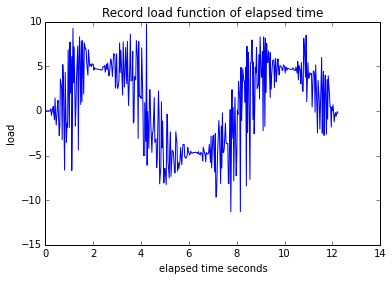

In [8]:
figure(1)
plot(graph.pypot_time,graph.load['m3'])
xlabel('elapsed time seconds')
ylabel('load')
title ('Record load function of elapsed time')

In [22]:
class Filter_PID:
    def __init__(self,nb_record=10,goal=0):
        self.nb_record = nb_record
        self.goal = goal
        self.record_pos=[0 for i in range(nb_record)]
        self.filter_load=[[0,0] for i in range(nb_record*10)]
        
    def add(self,l,t):
        self.record_pos.append(l-self.goal)
        del self.record_pos[0]
        self.filter_load.append([t,sum(self.record_pos)/len(self.record_pos)])
        del self.filter_load[0]
    
    def integrate(self,nb_values=10):
        x=[i[0] for i in self.filter_load]
        y=[i[1] for i in self.filter_load]
        return np.trapz(y[-nb_values-1:-1],x[-nb_values-1:-1])
       
    def derivative(self):
        if self.filter_load[-1][0] != 0:
            return ((self.filter_load[-1][1]+self.filter_load[-2][1])/2-(self.filter_load[-10][1]+self.filter_load[-9][1])/2)/((self.filter_load[-1][0]+self.filter_load[-2][0])/2-(self.filter_load[-10][0]+self.filter_load[-9][0])/2)
        else :
            return 0
    
    def last(self):
        return self.filter_load[-1][1]

In [7]:
class Load_primitive(Primitive):
    def __init__(self,robot,motors_name):
        self.robot = robot
        Primitive.__init__(self, robot)  
        self.fake_motors = getattr(self.robot, motors_name) 
    
    def setup(self):
        self.load=Filter_PID(30)
        self.filter_load=[]
        self.python_time=[]
        self.pypot_time=[]
        
    
    def run(self):
        t0 = time.time()
        while not self.should_stop():
            self.load.add(self.fake_motors.present_load,self.elapsed_time)
            self.filter_load.append(self.load.last())
            self.python_time.append(time.time()-t0)
            self.pypot_time.append(self.elapsed_time)
            time.sleep(0.02)

In [8]:
load = Load_primitive(mini_dof,'m3')

In [9]:
load.start()
mini_dof.m2.goto_position(90,2,wait=True)
mini_dof.m2.goto_position(-90,4,wait=True)
mini_dof.m2.goto_position(90,4,wait=True)
mini_dof.m2.goto_position(0,2,wait=True)
load.stop()

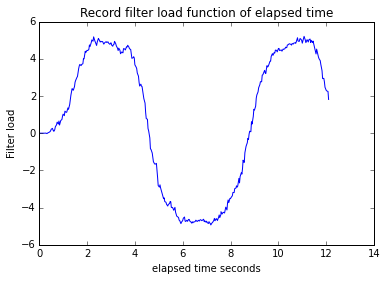

In [10]:
figure(1)
plot(load.pypot_time,load.filter_load)
xlabel('elapsed time seconds')
ylabel('Filter load')
title ('Record filter load function of elapsed time')

In [14]:
load.start()
mini_dof.m2.goto_position(90,2,wait=True)
time.sleep(2)
mini_dof.m3.goto_position(-90,2,wait=True)
time.sleep(2)
load.stop()
mini_dof.m2.goto_position(0,2)
mini_dof.m3.goto_position(0,2,wait=True)

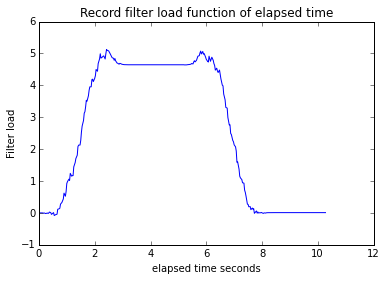

In [15]:
figure(1)
plot(load.pypot_time,load.filter_load)
xlabel('elapsed time seconds')
ylabel('Filter load')
title ('Record filter load function of elapsed time')

In [35]:
class Load_primitive_correction(Primitive):
    def __init__(self,robot,motors_name):
        self.robot = robot
        Primitive.__init__(self, robot)  
        self.fake_motors = getattr(self.robot, motors_name) 
        self.P=4
        self.I=1
        self.D=1
        
    
    def setup(self):
        self.load=Filter_PID(40)
        self.filter_load=[]
        self.python_time=[]
        self.pypot_time=[]
        self.P_record=[]
        self.I_record=[]
        self.D_record=[]
        self.correction=[]
        self.angle=self.fake_motors.present_position
        self.angle_record=[]
    
    
    
    def run(self):
        t0 = time.time()
        while not self.should_stop():
            # ajout du oresent load à l'objet Filter PID 
            self.load.add(self.fake_motors.present_load,self.elapsed_time)
            #ajout de la moyenne des load calculer par Filter PID
            self.filter_load.append(self.load.last())
            # ajout du temps
            self.python_time.append(time.time()-t0)
            self.pypot_time.append(self.elapsed_time)
            
            # calcul de la correction en fonction de l'écart avec l'objectif
            P = self.P*self.load.last()
            I = self.I*self.load.integrate(30)
            D = self.D*self.load.derivative()
            
            self.P_record.append(P)
            self.I_record.append(I)
            self.D_record.append(D)
            
            correction_value = P + D + I
            self.correction.append(correction_value)
            self.angle_record.append(self.angle)
            
            self.angle = self.fake_motors.present_position - correction_value
            self.fake_motors.goal_position = self.angle
            
            
            
            # pause déterminant la fréquance de la boucle
            t1 = self.elapsed_time
            while self.elapsed_time-t1<0.02:
                time.sleep(0.001)

In [36]:
load = Load_primitive_correction(mini_dof,'m3')

In [42]:
load.start()
mini_dof.m2.goto_position(90,4,wait=True)


mini_dof.m2.goto_position(0,4,wait=True)
time.sleep(1)

load.stop()
mini_dof.m3.goto_position(0,2)


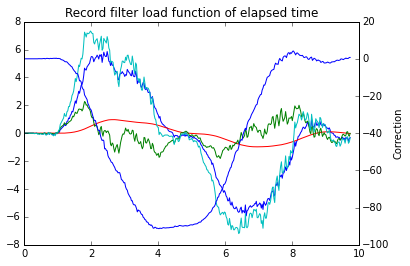

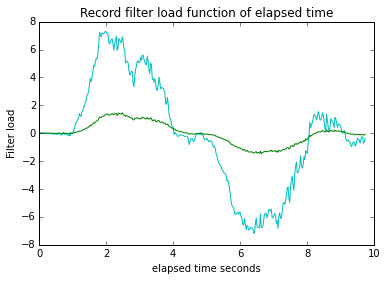

In [43]:
figure(1)
plot(load.pypot_time,load.P_record,'b-')
plot(load.pypot_time,load.I_record,'r-')
plot(load.pypot_time,load.D_record,'g-')
plot(load.pypot_time,load.correction,'c-')
twinx()
plot(load.pypot_time,load.angle_record,'b-')
xlabel('elapsed time seconds')
ylabel('Correction')
title ('Record filter load function of elapsed time')

figure(2)
plot(load.pypot_time,load.correction,'c-')
plot(load.pypot_time,load.filter_load,'g-')
xlabel('elapsed time seconds')
ylabel('Filter load')
title ('Record filter load function of elapsed time')


In [75]:
mini_dof.reset_simulation()